## Faces recognition example using eigenfaces and SVMs

Authors: The scikit-learn developers

SPDX-License-Identifier: BSD-3-Clause


In [143]:
from time import time

import matplotlib.pyplot as plt
from scipy.stats import loguniform

from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC  

import os
import numpy as np
from skimage.io import imread
from skimage.transform import resize
from sklearn.preprocessing import LabelEncoder


In [144]:
import cv2

def load_images_from_directory(dataset_path, image_size=(250, 250)):
    images = []
    labels = []
    label_encoder = LabelEncoder()  # Para convertir las etiquetas (nombres) en números
    
    # Recorre cada carpeta (que corresponde a un individuo)
    for person_name in os.listdir(dataset_path):
        person_folder = os.path.join(dataset_path, person_name)
        
        # Si el directorio no contiene imágenes, lo ignoramos
        if not os.path.isdir(person_folder):
            continue
        
        # Recorre las imágenes dentro de la carpeta de la persona
        for image_name in os.listdir(person_folder):
            image_path = os.path.join(person_folder, image_name)
            
            # Carga la imagen
            img = cv2.imread(image_path)
            if img is not None:
                # Convierte a escala de grises
                gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                
                # Redimensiona la imagen
                resized_img = cv2.resize(gray_img, image_size)
                
                # Añade la imagen y la etiqueta a las listas
                images.append(resized_img)
                labels.append(person_name)
    
    # Convierte las listas a arrays de NumPy
    images = np.array(images)
    images = images.reshape(images.shape[0], -1)  # Aplana las imágenes en vectores
    
    # Codifica las etiquetas (nombres de las personas) en números
    labels = label_encoder.fit_transform(labels)
    
    return images, labels, label_encoder.classes_

# Ruta de tu dataset (ajusta esto según tu estructura de carpetas)
dataset_path = "./wicked_dataset"

# Cargar las imágenes
X, y, target_names = load_images_from_directory(dataset_path)

# Verifica las dimensiones del dataset
n_samples, n_features = X.shape
n_classes = len(target_names)

# Imprimir la información
print("Total dataset size:")
print(f"n_samples: {n_samples}")
print(f"n_features: {n_features}")
print(f"n_classes: {n_classes}")

# Mostrar los nombres de las personas (target_names)
print("Target names:")
print(target_names)


Total dataset size:
n_samples: 226
n_features: 62500
n_classes: 6
Target names:
['Ariana_Grande' 'Cynthia_Erivo' 'Jeff_Goldblum' 'Jonathan_Bailey'
 'Michelle_Yeoh' 'Peter_Dinklage']


Split into a training set and a test and keep 25% of the data for testing.

In [145]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled dataset): unsupervised feature extraction / dimensionality reduction

In [146]:
# This value depend of the total of samples (must to be lower)
n_components = 100

pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True).fit(X_train)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


Train a SVM classification model

In [147]:
param_grid = {
    "C": loguniform(1e3, 1e5),
    "gamma": loguniform(1e-4, 1e-1),
}

# cv es el numero de muestras que tiene cada clase
clf = RandomizedSearchCV(
    SVC(kernel="rbf", class_weight="balanced"), param_grid, n_iter=50, cv=2 
)
clf = clf.fit(X_train_pca, y_train)
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Best estimator found by grid search:
SVC(C=12056.402815083351, class_weight='balanced', gamma=0.004409857620788756)


Quantitative evaluation of the model quality on the test set

Predicting people's names on the test set
done in 0.001s
                 precision    recall  f1-score   support

  Ariana_Grande       0.30      0.86      0.44         7
  Cynthia_Erivo       0.33      0.40      0.36        10
  Jeff_Goldblum       0.00      0.00      0.00         7
Jonathan_Bailey       0.17      0.09      0.12        11
  Michelle_Yeoh       0.50      0.10      0.17        10
 Peter_Dinklage       0.47      0.58      0.52        12

       accuracy                           0.33        57
      macro avg       0.29      0.34      0.27        57
   weighted avg       0.31      0.33      0.28        57



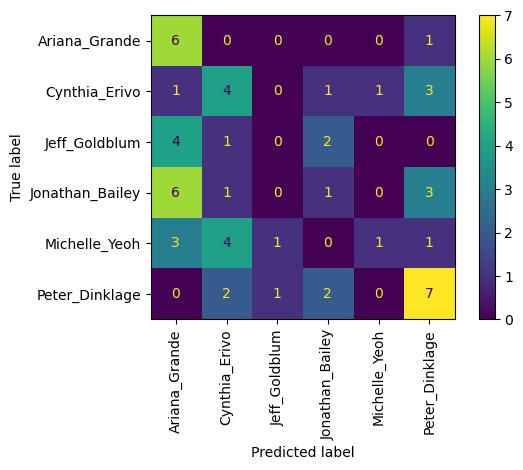

In [148]:
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
ConfusionMatrixDisplay.from_estimator(
    clf, X_test_pca, y_test, display_labels=target_names, xticks_rotation="vertical"
)
plt.tight_layout()
plt.show()

Qualitative evaluation of the predictions using matplotlib

In [149]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(12, 8))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

plot the result of the prediction on a portion of the test set

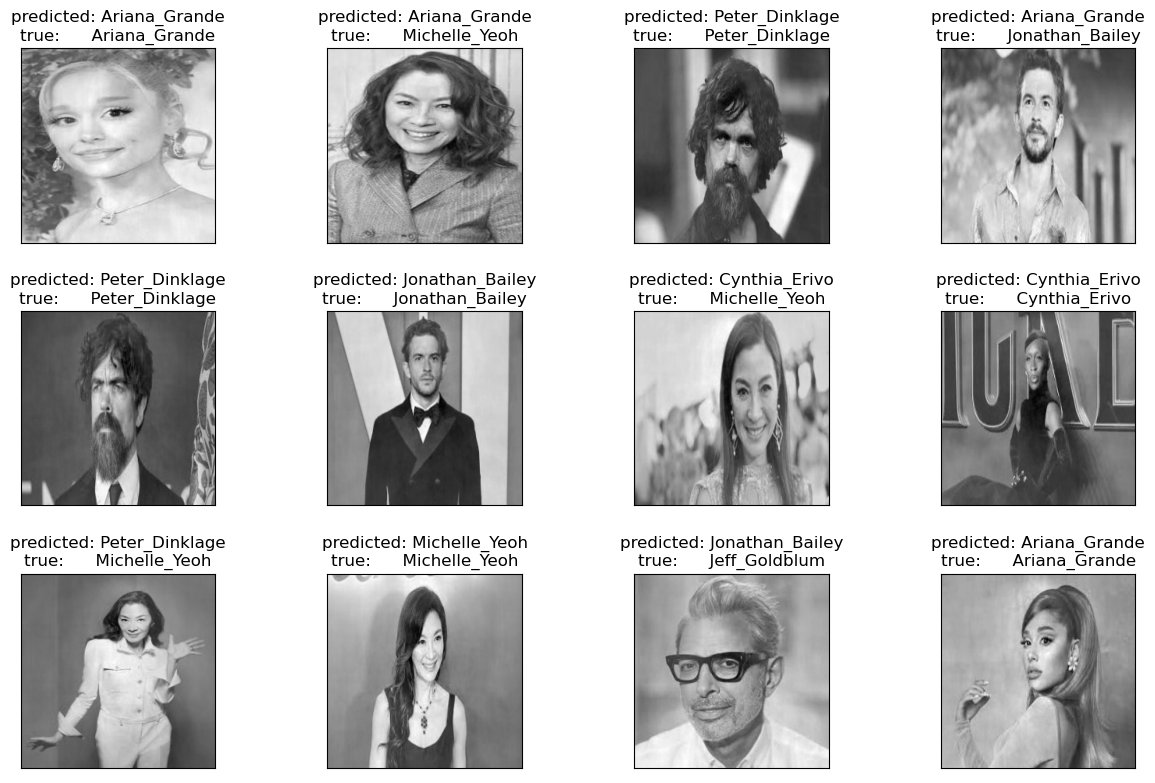

In [150]:

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(" ", 1)[-1]
    true_name = target_names[y_test[i]].rsplit(" ", 1)[-1]
    return "predicted: %s\ntrue:      %s" % (pred_name, true_name)


prediction_titles = [
    title(y_pred, y_test, target_names, i) for i in range(y_pred.shape[0])
]

plot_gallery(X_test, prediction_titles, 250, 250)